In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class CustomGoogLeNet(nn.Module):
    def __init__(self, num_classes=102):
        super(CustomGoogLeNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

class CustomDataset(Dataset):
    def __init__(self, txt_file, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        with open(txt_file, 'r') as f:
            self.img_list = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.img_list[idx].split('.')[0]) % 102
        return image, label

Using device: cuda
Starting training...

Epoch 1/30
Learning Rate: 0.010000


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Train Loss: 5.2412 Acc: 0.97%
Val Loss: 4.6380 Acc: 0.60%
Saved new best model with accuracy: 0.60%

Epoch 2/30
Learning Rate: 0.012725


Validating: 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]


Train Loss: 4.6331 Acc: 0.83%
Val Loss: 4.6437 Acc: 0.60%

Epoch 3/30
Learning Rate: 0.020569


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Train Loss: 4.6375 Acc: 0.77%
Val Loss: 4.6492 Acc: 0.60%

Epoch 4/30
Learning Rate: 0.032583


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


Train Loss: 4.6445 Acc: 0.77%
Val Loss: 4.6503 Acc: 0.80%
Saved new best model with accuracy: 0.80%

Epoch 5/30
Learning Rate: 0.047311


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


Train Loss: 4.6553 Acc: 0.97%
Val Loss: 4.6607 Acc: 1.40%
Saved new best model with accuracy: 1.40%

Epoch 6/30
Learning Rate: 0.062971


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]


Train Loss: 5.4028 Acc: 0.80%
Val Loss: 4.8137 Acc: 1.20%

Epoch 7/30
Learning Rate: 0.077665


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


Train Loss: 5.4665 Acc: 0.60%
Val Loss: 4.6902 Acc: 0.60%

Epoch 8/30
Learning Rate: 0.089615


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]


Train Loss: 5.2724 Acc: 0.80%
Val Loss: 4.6972 Acc: 0.60%

Epoch 9/30
Learning Rate: 0.097372


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.91it/s]


Train Loss: 5.3654 Acc: 0.83%
Val Loss: 4.6848 Acc: 0.80%

Epoch 10/30
Learning Rate: 0.100000


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]


Train Loss: 4.6885 Acc: 0.86%
Val Loss: 4.6800 Acc: 1.00%

Epoch 11/30
Learning Rate: 0.099421


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Train Loss: 4.7016 Acc: 0.86%
Val Loss: 4.7175 Acc: 0.80%

Epoch 12/30
Learning Rate: 0.097739


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]


Train Loss: 4.7240 Acc: 0.71%
Val Loss: 4.6927 Acc: 0.40%

Epoch 13/30
Learning Rate: 0.094990


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]


Train Loss: 4.6912 Acc: 0.71%
Val Loss: 4.6758 Acc: 1.00%

Epoch 14/30
Learning Rate: 0.091236


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]


Train Loss: 4.6787 Acc: 0.83%
Val Loss: 4.6788 Acc: 0.60%

Epoch 15/30
Learning Rate: 0.086561


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


Train Loss: 4.6838 Acc: 0.86%
Val Loss: 4.7019 Acc: 0.00%

Epoch 16/30
Learning Rate: 0.081070


Validating: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]


Train Loss: 4.6723 Acc: 0.69%
Val Loss: 4.6631 Acc: 1.00%

Epoch 17/30
Learning Rate: 0.074885


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


Train Loss: 4.6704 Acc: 0.63%
Val Loss: 4.6684 Acc: 0.60%

Epoch 18/30
Learning Rate: 0.068144


Validating: 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]


Train Loss: 4.6678 Acc: 0.69%
Val Loss: 4.6629 Acc: 0.60%

Epoch 19/30
Learning Rate: 0.060997


Validating: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]


Train Loss: 4.6644 Acc: 0.74%
Val Loss: 4.6692 Acc: 0.60%

Epoch 20/30
Learning Rate: 0.053606


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]


Train Loss: 4.6617 Acc: 0.57%
Val Loss: 4.6535 Acc: 1.00%

Epoch 21/30
Learning Rate: 0.046133


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Train Loss: 4.6549 Acc: 0.86%
Val Loss: 4.6387 Acc: 1.20%

Epoch 22/30
Learning Rate: 0.038748


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


Train Loss: 4.6484 Acc: 0.94%
Val Loss: 4.6509 Acc: 0.60%

Epoch 23/30
Learning Rate: 0.031613


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]


Train Loss: 4.6423 Acc: 0.69%
Val Loss: 4.6428 Acc: 0.60%

Epoch 24/30
Learning Rate: 0.024890


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Train Loss: 4.6378 Acc: 0.63%
Val Loss: 4.6497 Acc: 0.60%

Epoch 25/30
Learning Rate: 0.018727


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


Train Loss: 4.6318 Acc: 0.91%
Val Loss: 4.6462 Acc: 0.60%

Epoch 26/30
Learning Rate: 0.013264


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Train Loss: 4.6291 Acc: 1.00%
Val Loss: 4.6465 Acc: 0.00%

Epoch 27/30
Learning Rate: 0.008621


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Train Loss: 4.6267 Acc: 1.17%
Val Loss: 4.6446 Acc: 0.00%

Epoch 28/30
Learning Rate: 0.004902


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]


Train Loss: 4.6243 Acc: 0.94%
Val Loss: 4.6447 Acc: 0.60%

Epoch 29/30
Learning Rate: 0.002191


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.91it/s]


Train Loss: 4.6229 Acc: 1.17%
Val Loss: 4.6448 Acc: 0.60%

Epoch 30/30
Learning Rate: 0.000548


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Train Loss: 4.6222 Acc: 1.17%
Val Loss: 4.6448 Acc: 0.60%


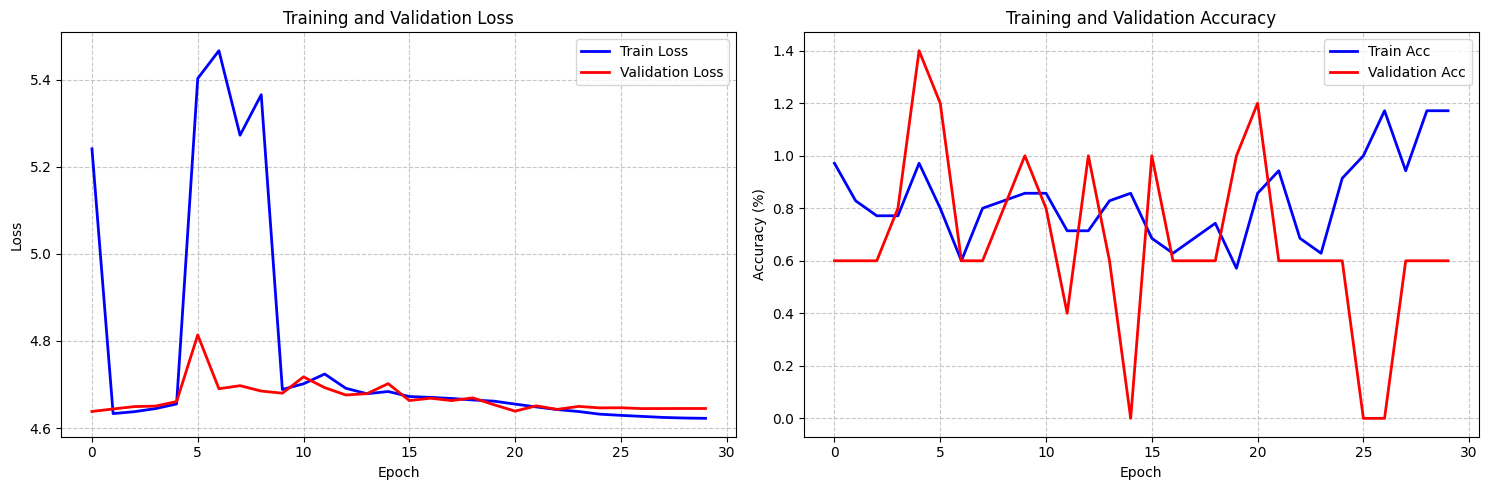

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    device = next(model.parameters()).device
    best_val_acc = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validating'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs,
                'best_acc': best_val_acc,
            }, os.path.join(base_path, 'best_custom_googlenet.pth'))
            print(f'Saved new best model with accuracy: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs

if __name__ == '__main__':
    # Set random seed
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Set paths
    base_path = '/content/drive/MyDrive/ip102_v1.1-001/ip102_v1.1'
    img_dir = os.path.join(base_path, 'images')
    train_txt = os.path.join(base_path, 'train.txt')
    val_txt = os.path.join(base_path, 'val.txt')
    test_txt = os.path.join(base_path, 'test.txt')

    # Data augmentation
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = CustomDataset(train_txt, img_dir, transform=transform_train)
    val_dataset = CustomDataset(val_txt, img_dir, transform=transform_test)
    test_dataset = CustomDataset(test_txt, img_dir, transform=transform_test)

    # Batch size
    batch_size = 64

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')

    # Create model
    model = CustomGoogLeNet(num_classes=102)
    model = model.to(device)

    # Define loss function and optimizer with higher learning rates
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    optimizer = optim.AdamW([
    {'params': model.conv1.parameters()},
    {'params': model.conv2.parameters()},
    {'params': model.inception3a.parameters()},
    {'params': model.inception3b.parameters()},
    {'params': model.inception4a.parameters()},
    {'params': model.inception4b.parameters()},
    {'params': model.inception4c.parameters()},
    {'params': model.inception4d.parameters()},
    {'params': model.inception4e.parameters()},
    {'params': model.inception5a.parameters()},
    {'params': model.inception5b.parameters()},
    {'params': model.fc.parameters(), 'lr': 0.2}  # 更高的学习率
    ], lr=0.1, weight_decay=0.0001)  # 基础学习率提高到0.05

# Learning rate scheduler
    scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[0.1] * 11 + [0.2],  # 对应更高的学习率
    epochs=30,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    div_factor=10.0,
    final_div_factor=1e3
    )

    # Train model
    print("Starting training...")
    try:
        # Train the model
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler)

        # After training, plot curves
        plt.figure(figsize=(15, 5))

        # Loss subplot
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # Accuracy subplot
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc', color='blue', linewidth=2)
        plt.plot(val_accs, label='Validation Acc', color='red', linewidth=2)
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during execution: {str(e)}")
        import traceback
        traceback.print_exc()

# Function to view training curves from saved checkpoint
def plot_training_curves_from_checkpoint():
    checkpoint = torch.load(os.path.join(base_path, 'best_custom_googlenet.pth'))

    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accs = checkpoint['train_accs']
    val_accs = checkpoint['val_accs']

    plt.figure(figsize=(15, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', color='blue', linewidth=2)
    plt.plot(val_accs, label='Validation Acc', color='red', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()